In [ ]:
!wget https://storage.cloud.google.com/bigbird-transformer/pretrain/bigbr_large/model.ckpt-0.data-00000-of-00001?_ga=2.84365211.-320056617.1608952090

In [ ]:
!wget https://storage.cloud.google.com/bigbird-transformer/pretrain/bigbr_large/model.ckpt-0.index?_ga=2.47138981.-320056617.1608952090

In [ ]:
!pip install transformers
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/config.json 
!tar -xzvf pytorch_weights.tar.gz
!mv config.json pytorch/.
!mv vocab.txt pytorch/.

     |████████████████████████████████| 2.1MB 6.5MB/s 
     |████████████████████████████████| 901kB 33.4MB/s 
     |████████████████████████████████| 3.3MB 39.9MB/s 
--2021-05-10 15:51:52--  https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 200.9.99.211, 192.80.24.4
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|200.9.99.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409871727 (391M) [application/x-gzip]
Saving to: ‘pytorch_weights.tar.gz’

pytorch_weights.tar 100%[===================>] 390.88M  3.45MB/s    in 65s     

2021-05-10 15:52:57 (6.06 MB/s) - ‘pytorch_weights.tar.gz’ saved [409871727/409871727]

--2021-05-10 15:52:57--  https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4, 200.9.99.211
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:443... connected.
HTTP request s

In [ ]:
!wc -l /content/hindi-vocab.txt

30000 /content/hindi-vocab.txt


In [ ]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: hindi-vocab.txt         


In [ ]:
import os
import random
import itertools
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import re
import string
import nltk
from nltk.corpus import stopwords
from transformers import TFAutoModel, AutoTokenizer, BertConfig, TFBertModel

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [ ]:
!unzip /content/public_dat.zip

Archive:  /content/public_dat.zip
  inflating: test.xlsx               
  inflating: train.xlsx              


In [ ]:
!unzip /content/dataset_phase2.zip

Archive:  /content/dataset_phase2.zip
   creating: dataset_phase2/
  inflating: dataset_phase2/test.xlsx  


In [ ]:
import pandas as pd
train = pd.read_excel("/content/train.xlsx")
testt = pd.read_excel("/content/test.xlsx")
actual_test = pd.read_excel("/content/dataset_phase2/test.xlsx")

In [ ]:
train = pd.concat([train,testt])

In [ ]:
actual_test.columns = ['Id',"Headline","Text"]

In [ ]:
train['Text'] = train['Text'].apply(str).apply(lambda x: text_preprocessing(x))
actual_test['Text'] = actual_test['Text'].apply(str).apply(lambda x: text_preprocessing(x))

In [ ]:
train['Headline'] = train['Headline'].apply(str).apply(lambda x: text_preprocessing(x))
actual_test['Headline'] = actual_test['Headline'].apply(str).apply(lambda x: text_preprocessing(x))

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [ ]:
### READ DATA ###

df = train
df = df[df.Category.isin(df.Category.value_counts().tail(8).index)].copy() # select 8 low dimensional categories
map_label = dict(enumerate(df.Category.factorize()[1]))
df['Category'] = df.Category.factorize()[0]

print(df.shape)
df.head()

(971, 7)


,Id,Category,Topic,Source,Headline,Text,Link
0,1,0,Education,El Ruinaversal,rae incluirá la palabra lady en el diccionario...,rae incluirá la palabra lady en el diccionario...,http://www.elruinaversal.com/2017/06/10/rae-in...
1,2,0,Education,Hay noticia,la palabra haiga aceptada por la rae,la palabra haiga aceptada por la rae la real a...,https://haynoticia.es/la-palabra-haiga-aceptad...
2,3,0,Education,El Ruinaversal,yordi rosado escribirá y diseñará los nuevos l...,yordi rosado escribirá y diseñará los nuevos l...,http://www.elruinaversal.com/2018/05/06/yordi-...
3,4,1,Education,EL UNIVERSAL,unam capacitará a maestros para aprobar prueba...,unam capacitará a maestros para aprobar prueba...,http://www.eluniversal.com.mx/articulo/nacion/...
4,5,0,Education,Lamula,pretenden aprobar libros escolares con conteni...,alerta pretenden aprobar libros escolares con ...,https://redaccion.lamula.pe/2018/06/19/memoria...


In [ ]:
### UTILITY FUNCTIONS FOR TOKENIZATIONS, MASKS AND SEGMENTS CREATION ###
### from: https://www.kaggle.com/akensert/bert-base-tf2-0-now-huggingface-transformer

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def convert_to_transformer_inputs(str1, str2, tokenizer, max_sequence_length, double=True):
    
    def return_id(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,
            add_special_tokens=True,
            max_length=length,
            truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_masks = [1] * len(input_ids)
        input_segments = inputs["token_type_ids"]
        
        padding_length = length - len(input_ids)
        padding_id = tokenizer.pad_token_id
        
        input_ids = input_ids + ([padding_id] * padding_length)
        input_masks = input_masks + ([0] * padding_length)
        input_segments = input_segments + ([0] * padding_length)
        
        return [input_ids, input_masks, input_segments]
    
    if double:
    
        input_ids_1, input_masks_1, input_segments_1 = return_id(
            str1, None, 'longest_first', max_sequence_length)

        input_ids_2, input_masks_2, input_segments_2 = return_id(
            str2, None, 'longest_first', max_sequence_length)

        return [input_ids_1, input_masks_1, input_segments_1,
                input_ids_2, input_masks_2, input_segments_2]
    
    else:
        
        input_ids, input_masks, input_segments = return_id(
            str1, str2, 'longest_first', max_sequence_length)

        return [input_ids, input_masks, input_segments,
                None, None, None]        

def compute_input_arrays(df, columns, tokenizer, max_sequence_length, double=True):
    
    input_ids_1, input_masks_1, input_segments_1 = [], [], []
    input_ids_2, input_masks_2, input_segments_2 = [], [], []
    for _, instance in tqdm(df[columns].iterrows(), total=len(df)):
        str1, str2 = instance[columns[0]], instance[columns[1]]

        ids_1, masks_1, segments_1, ids_2, masks_2, segments_2 = \
        convert_to_transformer_inputs(str1, str2, tokenizer, max_sequence_length, double=double)
        
        input_ids_1.append(ids_1)
        input_masks_1.append(masks_1)
        input_segments_1.append(segments_1)

        input_ids_2.append(ids_2)
        input_masks_2.append(masks_2)
        input_segments_2.append(segments_2)
        
    if double:
        
        return [np.asarray(input_ids_1, dtype=np.int32), 
                np.asarray(input_masks_1, dtype=np.int32), 
                np.asarray(input_segments_1, dtype=np.int32),
                np.asarray(input_ids_2, dtype=np.int32), 
                np.asarray(input_masks_2, dtype=np.int32), 
                np.asarray(input_segments_2, dtype=np.int32)]
    
    else:
        
        return [np.asarray(input_ids_1, dtype=np.int32), 
                np.asarray(input_masks_1, dtype=np.int32), 
                np.asarray(input_segments_1, dtype=np.int32)]

In [ ]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df[['Headline','Text']], df['Category'].values, 
                                                    random_state=33, test_size = 0.003,stratify = df['Category'].values)
# del df

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(968, 2) (3, 2)
(968,) (3,)


In [ ]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup


In [ ]:
### IMPORT TOKENIZER ###

MAX_SEQUENCE_LENGTH = 256

model_name = '/content/pytorch/vocab.txt'
tokenizer = BertTokenizer.from_pretrained(model_name, truncation=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1621: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  FutureWarning,


# **SIMPLE BERT (ONE INPUT)**

In [ ]:
### CREATE SEQUENCES (id, mask, segments) FOR TRAIN AND TEST ###

input_train = compute_input_arrays(X_train, ['Headline','Text'], tokenizer, MAX_SEQUENCE_LENGTH, double=False)
input_test = compute_input_arrays(X_test, ['Headline','Text'], tokenizer, MAX_SEQUENCE_LENGTH, double=False)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
def simple_bert():
    
    set_seed(33)
    
    opt = Adam(learning_rate=1e-5)
    
    id_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    mask_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    atn_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
 # Set to True to obtain hidden states
    bert_model = TFBertModel.from_pretrained('/content/pytorch', config="/content/pytorch/config.json",from_pt=True)
    config = bert_model.config
    config.output_hidden_states = False
    embedding = bert_model(id_, attention_mask=mask_, token_type_ids=atn_)[0]
    x = GlobalAveragePooling1D()(embedding)    
    x = Dropout(0.20)(x)
    out = Dense(len(map_label), activation='softmax')(x)

    model = Model(inputs=[id_, mask_, atn_], outputs=out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)
    
    return model

In [ ]:
import gc
gc.collect()

1897

In [ ]:
16,106,127,360 

In [ ]:
model = simple_bert()
model.fit(input_train, y_train, epochs=3, batch_size=32)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
### PREDICT TEST ###

pred_test = np.argmax(model.predict(input_test), axis=1)

In [ ]:
print(classification_report([map_label[i] for i in y_test], [map_label[i] for i in pred_test]))

              precision    recall  f1-score   support

        Fake       0.50      1.00      0.67         1
        True       1.00      0.50      0.67         2

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



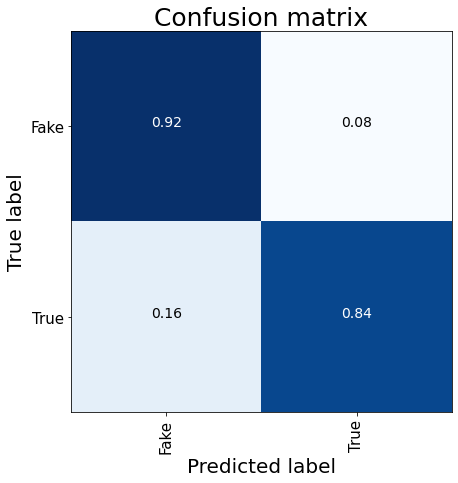

In [ ]:
cnf_matrix = confusion_matrix([map_label[i] for i in y_test], 
                              [map_label[i] for i in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(map_label.values()))
plt.show()

In [ ]:
actual_test['Headline'].values[2]

'la comunidad musulmana catalana denuncia a vox por incitar al odio'

In [ ]:
actual_test = actual_test[['Headline','Text']]

In [ ]:
from collections import Counter

In [ ]:
Counter(actual_test.isna()["Text"])

Counter({False: 572})

In [ ]:
heads =[]
tex = []
for headline,text in zip(actual_test.Text.values,actual_test.Text.values):
  if headline =="nan":
    headline = text.split(" ")[:7]
  heads.append(headline)
  tex.append(tex)


In [ ]:
actual_test = pd.DataFrame(zip(heads,tex),columns=['Headline','Text'])

In [ ]:
actual_test.shape

(572, 2)

In [ ]:
actual_test.head()

KeyboardInterrupt: ignored

In [ ]:
import numpy as np
actual_test = actual_test.replace(np.nan, 'ok', regex=True)

In [ ]:
input_actual_test = compute_input_arrays(actual_test, ['Headline','Text'], tokenizer, MAX_SEQUENCE_LENGTH, double=False)

In [ ]:
pred_actual_test = np.argmax(model.predict(input_actual_test), axis=1)

In [ ]:
from collections import Counter

In [ ]:
pred_actual_test

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,

In [ ]:
Counter(pred_actual_test)

Counter({0: 286, 1: 286})

In [ ]:
def to_label(rating):
  if rating == 0:
    return 'Fake'
  else:
    return 'True'

In [ ]:
results = list(map(to_label,pred_actual_test))

In [ ]:
results

['Fake',
 'Fake',
 'True',
 'True',
 'True',
 'True',
 'True',
 'Fake',
 'True',
 'True',
 'Fake',
 'True',
 'True',
 'Fake',
 'True',
 'Fake',
 'True',
 'True',
 'Fake',
 'Fake',
 'True',
 'Fake',
 'True',
 'True',
 'Fake',
 'True',
 'True',
 'True',
 'Fake',
 'True',
 'True',
 'Fake',
 'True',
 'True',
 'Fake',
 'Fake',
 'True',
 'Fake',
 'True',
 'Fake',
 'True',
 'True',
 'Fake',
 'Fake',
 'Fake',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 'Fake',
 'True',
 'Fake',
 'Fake',
 'Fake',
 'True',
 'Fake',
 'True',
 'Fake',
 'True',
 'Fake',
 'True',
 'True',
 'True',
 'Fake',
 'True',
 'True',
 'True',
 'True',
 'True',
 'Fake',
 'Fake',
 'True',
 'Fake',
 'True',
 'True',
 'True',
 'True',
 'Fake',
 'Fake',
 'True',
 'True',
 'Fake',
 'True',
 'True',
 'True',
 'Fake',
 'True',
 'Fake',
 'Fake',
 'True',
 'Fake',
 'Fake',
 'Fake',
 'True',
 'True',
 'True',
 'True',
 'True',
 'Fake',
 'True',
 'True',
 'True',
 'Fake',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 

In [ ]:
with open('final2.txt', 'w+') as f:
  counter = 1
  for item in results:
    cter = '"'+str(counter)+'"'
    item = '"'+str(item)+'"'
    f.write('"fakenews" '+ cter+" "+ "%s\n" % item)
    counter+=1

# **DUAL BERT (TWO INPUT)**

In [ ]:
### CREATE SEQUENCES (id, mask, segments) FOR TRAIN AND TEST ###

input_train = compute_input_arrays(X_train, ['Headline','Text'], tokenizer, MAX_SEQUENCE_LENGTH)
input_test = compute_input_arrays(X_test, ['Headline','Text'], tokenizer, MAX_SEQUENCE_LENGTH)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
def dual_bert():
    
    set_seed(33)
    
    opt = Adam(learning_rate=2e-5)
    
    id1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    id2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    mask1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    mask2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    atn1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    atn2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
 # Set to True to obtain hidden states
    bert_model1 = TFBertModel.from_pretrained('/content/pytorch', config="/content/pytorch/config.json",from_pt=True)
    bert_model2 = TFBertModel.from_pretrained('/content/pytorch', config="/content/pytorch/config.json",from_pt=True)
    config = bert_model1.config
    config.output_hidden_states = False
    embedding1 = bert_model1(id1, attention_mask=mask1, token_type_ids=atn1)[0]
    embedding2 = bert_model2(id2, attention_mask=mask2, token_type_ids=atn2)[0]
    
    x1 = GlobalAveragePooling1D()(embedding1)
    x2 = GlobalAveragePooling1D()(embedding2)
    
    x = Concatenate()([x1, x2])
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(len(map_label), activation='softmax')(x)

    model = Model(inputs=[id1, mask1, atn1, id2, mask2, atn2], outputs=out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)
    
    return model

In [ ]:
model = dual_bert()
model.fit(input_train, y_train, epochs=3, batch_size=1)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Epoch 1/3
922/922 [==============================] - 195s 186ms/step - loss: 0.6551
Epoch 2/3
922/922 [==============================] - 171s 186ms/step - loss: 0.3470
Epoch 3/3
922/922 [==============================] - 171s 186ms/step - loss: 0.3150


In [ ]:
### PREDICT TEST ###

pred_test = np.argmax(model.predict(input_test), axis=1)

In [ ]:
print(classification_report([map_label[i] for i in y_test], [map_label[i] for i in pred_test]))

              precision    recall  f1-score   support

        Fake       0.45      1.00      0.62        22
        True       0.00      0.00      0.00        27

    accuracy                           0.45        49
   macro avg       0.22      0.50      0.31        49
weighted avg       0.20      0.45      0.28        49



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


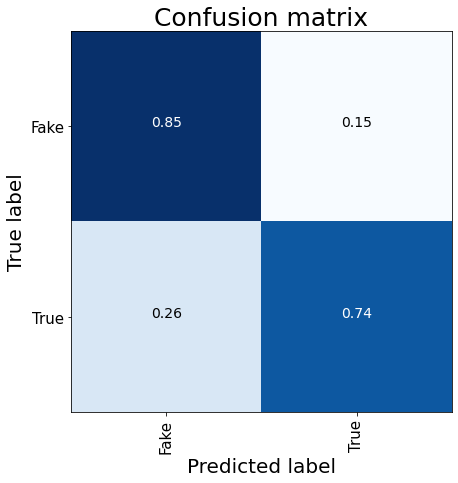

In [ ]:
cnf_matrix = confusion_matrix([map_label[i] for i in y_test], 
                              [map_label[i] for i in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(map_label.values()))
plt.show()

# **SIAMESE BERT (TWO INPUT)**

In [ ]:
def siamese_bert():
    
    set_seed(33)
    
    opt = Adam(learning_rate=2e-5)
    
    id1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    id2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    mask1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    mask2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    atn1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    atn2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    bert_model = TFBertModel.from_pretrained('/content/pytorch', config="/content/pytorch/config.json",from_pt=True)
    config = bert_model.config
    config.output_hidden_states = False
    
    embedding1 = bert_model(id1, attention_mask=mask1, token_type_ids=atn1)[0]
    embedding2 = bert_model(id2, attention_mask=mask2, token_type_ids=atn2)[0]
    
    x1 = GlobalAveragePooling1D()(embedding1)
    x2 = GlobalAveragePooling1D()(embedding2)
    
    x = Concatenate()([x1, x2])
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(len(map_label), activation='softmax')(x)

    model = Model(inputs=[id1, mask1, atn1, id2, mask2, atn2], outputs=out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)
    
    return model

In [ ]:

model = siamese_bert()
model.fit(input_train, y_train, epochs=3, batch_size=8)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Epoch 1/3
116/116 [==============================] - 141s 982ms/step - loss: 0.6507
Epoch 2/3
116/116 [==============================] - 114s 981ms/step - loss: 0.3255
Epoch 3/3
116/116 [==============================] - 114s 981ms/step - loss: 0.1334


In [ ]:
### PREDICT TEST ###

pred_test = np.argmax(model.predict(input_test), axis=1)

In [ ]:
print(classification_report([map_label[i] for i in y_test], [map_label[i] for i in pred_test]))

              precision    recall  f1-score   support

        Fake       0.78      0.75      0.77        24
        True       0.77      0.80      0.78        25

    accuracy                           0.78        49
   macro avg       0.78      0.78      0.78        49
weighted avg       0.78      0.78      0.78        49



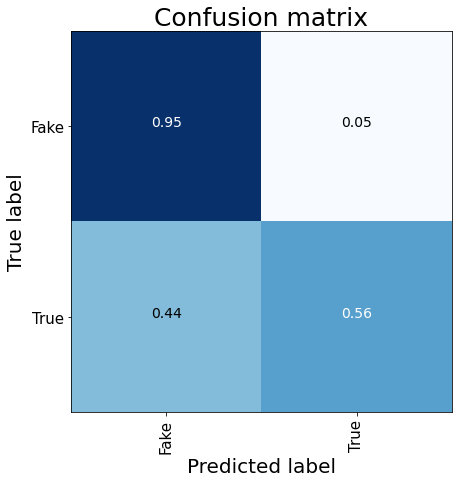

In [ ]:
cnf_matrix = confusion_matrix([map_label[i] for i in y_test], 
                              [map_label[i] for i in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(map_label.values()))
plt.show()